# Import all neccessary libraries

In [ ]:
import torch
import torch.nn as nn
from torchvision import transforms
from torchvision import models
from torchvision.utils import save_image

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

# Load 'content' and 'style' images from provided paths

In [ ]:
std = torch.tensor([0.229, 0.224, 0.225], device=device).view(-1, 1, 1)
mean = torch.tensor([0.485, 0.456, 0.406], device=device).view(-1, 1, 1)

def image_loader(path, transform):
    img = Image.open(path)
    img = transform(img).unsqueeze(0).to(device, torch.float)
    return img

def Normalize(image):
  image = image - mean
  image = image / std

  return image

def Denormalize(image):
  image = image * std
  image = image + mean

  return image

In [ ]:
image_size = (224, 224)

transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor()
])

content_image = image_loader('Capture.png', transform).detach()
style_image = image_loader('starry_night.png', transform).detach()
content_image = Normalize(content_image)
style_image = Normalize(style_image)
gen_image = content_image.clone().requires_grad_(True)

In [ ]:
#gen_image = (content_image + style_image).requires_grad_(True)

In [ ]:
#gen_image = (torch.randn(content_image.size(), device=device)).requires_grad_(True)

## Display images

In [ ]:
def plot_image(images, names=None, denorm=False):

  if type(images) is list:
    plt.figure(figsize=(5 * len(images), 8))

    for i in range(len(images)):
      if denorm:
        image = images[i] * std + mean
      else:
        image = images[i]

      plt.subplot(1, len(images), i + 1)

      if names == None:
        plt.title('Image {}'.format(i))
      else:
        plt.title(names[i])

      plt.imshow(image.squeeze(0).permute(1, 2, 0).cpu())
      plt.axis('off')

    plt.show()
  else:
    if denorm:
      image = images * std + mean
    else:
      image = images

    plt.figure(figsize=(4, 8))

    plt.subplot(1, 1, 1)
    plt.title('Content Image')
    plt.imshow(image.squeeze(0).permute(1, 2, 0).cpu())
    plt.axis('off')

    plt.show()

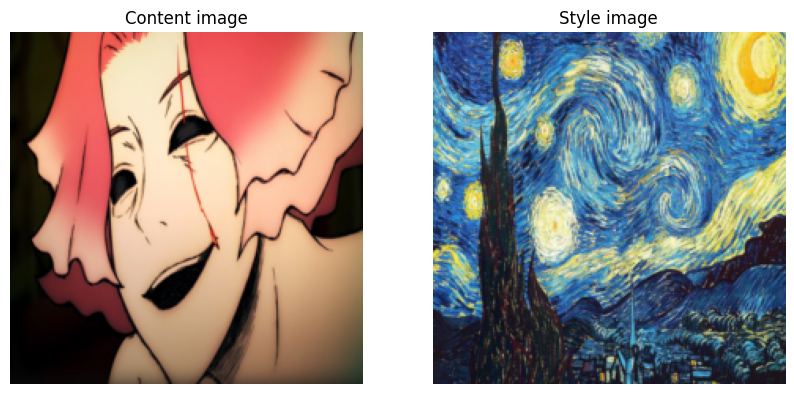

In [ ]:
plot_image([content_image, style_image], names=['Content image', 'Style image'], denorm=True)

# Define the Model

In [ ]:
Model = models.vgg19(pretrained=True).features

In [ ]:
for layer_num, layer in enumerate(Model):
  print(layer_num, layer)

0 Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
1 ReLU(inplace=True)
2 Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
3 ReLU(inplace=True)
4 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
5 Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
6 ReLU(inplace=True)
7 Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
8 ReLU(inplace=True)
9 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
10 Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
11 ReLU(inplace=True)
12 Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
13 ReLU(inplace=True)
14 Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
15 ReLU(inplace=True)
16 Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
17 ReLU(inplace=True)
18 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
19 Conv2d(256, 512, kernel_size=(3, 3)

In [ ]:
style_conv = ['conv_1', 'conv_3', 'conv_5', 'conv_9', 'conv_13']
content_conv = ['conv_10']

In [ ]:
# models/vgg19.py

class VGG(nn.Module):
    def __init__(self):
        super(VGG, self).__init__()

        self.model = models.vgg19(pretrained=True).features

    def forward(self, x):
        features = []
        for layer_num, layer in enumerate(self.model):
            x = layer(x)
            features.append(x)

        return features

# Loss Function

In [ ]:
# loss/content_loss.py
def content_loss(gen_feat, content_feat):
    return torch.div(torch.sum((gen_feat - content_feat) ** 2), 2)

def total_variation(y):
    return torch.sum(torch.abs(y[:, :, :, :-1] - y[:, :, :, 1:])) + \
           torch.sum(torch.abs(y[:, :, :-1, :] - y[:, :, 1:, :]))

# loss/style_loss.py
def style_loss(gen_feat, style_feat):
    batch_size, channel, height, width = gen_feat.shape

    G = torch.mm(
        gen_feat.view(channel, height * width),
        gen_feat.view(channel, height * width).t()
    )

    A = torch.mm(
        style_feat.view(channel, height * width),
        style_feat.view(channel, height * width).t()
    )

    return torch.div(torch.sum((G - A) ** 2), ((height * width * 2) ** 2))

# loss/loss.py
def criterion(gen_image, gen_feat, content_feat, style_feat, alpha, beta, tv):
    style_loss_total = 0
    content_loss_total = 0
    conv = 1
    tv_loss = total_variation(gen_image)

    for i, layer in enumerate(model.model):
      name = "WOW"
      if isinstance(layer, nn.Conv2d):
        name = "conv_{}".format(conv)
        conv += 1

      if name in content_conv:
        content_loss_total += content_loss(gen_feat[i], content_feat[i])

      if name in style_conv:
        style_loss_total += style_loss(gen_feat[i], style_feat[i])

    return (alpha * content_loss_total + beta * style_loss_total + tv * tv_loss), content_loss_total, style_loss_total, tv_loss

# Configure the parameters

In [ ]:
epochs = 1004
lr = 4e-3
tv = 1e0
alpha = 1e1
beta = 1e3 / len(style_conv)
verbose = 20


model = VGG().to(device).eval()
#optimizer = torch.optim.Adam([gen_image], lr=lr)
#optimizer = torch.optim.LBFGS([gen_image], lr=lr)

In [ ]:
cnt = 0

In [ ]:
loss_history = []

def train_():
  optimizer = torch.optim.LBFGS([gen_image,], max_iter=1000, line_search_fn='strong_wolfe')
  content_feat = model(content_image)
  style_feat = model(style_image)
  cnt = 0

  def closure():
    nonlocal cnt
    optimizer.zero_grad()
    gen_feat = model(gen_image)
    total_loss, content_loss, style_loss, tv_loss = criterion(gen_image, gen_feat, content_feat, style_feat, alpha, beta, tv)
    loss_history.append(total_loss.item())
    total_loss.backward(retain_graph=True)
    with torch.no_grad():
      print(f'L-BFGS | iteration: {cnt:03}, total loss={total_loss.item():12.4f}, content_loss={alpha * content_loss.item():12.4f}, style loss={beta * style_loss.item():12.4f}, tv loss={tv * tv_loss.item():12.4f}')

    cnt += 1
    return total_loss

  optimizer.step(closure)

train_()

L-BFGS | iteration: 000, total loss=906171520.0000, content_loss=      0.0000, style loss=906139687.5000, tv loss=  31804.8262
L-BFGS | iteration: 001, total loss=905252672.0000, content_loss=     12.7798, style loss=905220875.0000, tv loss=  31805.6133
L-BFGS | iteration: 002, total loss=897099264.0000, content_loss=   1262.0406, style loss=897066187.5000, tv loss=  31812.7168
L-BFGS | iteration: 003, total loss=857881984.0000, content_loss=  37812.5952, style loss=857812312.5000, tv loss=  31848.2617
L-BFGS | iteration: 004, total loss=698342400.0000, content_loss= 877890.3906, style loss=697432437.5000, tv loss=  32043.9258
L-BFGS | iteration: 005, total loss=478146080.0000, content_loss=5120393.1250, style loss=472993031.2500, tv loss=  32679.3477
L-BFGS | iteration: 006, total loss=401227200.0000, content_loss=7959496.2500, style loss=393234625.0000, tv loss=  33097.8203
L-BFGS | iteration: 007, total loss=339304992.0000, content_loss=12266250.0000, style loss=327004875.0000, tv l

# Train the Model

In [ ]:
epochs = len(loss_history)

In [ ]:
# loss_history = []
# gen_images = []
# content_feat = model(content_image)
# style_feat = model(style_image)

# for epoch in range(epochs):
#     gen_feat = model(gen_image)

#     optimizer.zero_grad()
#     loss = criterion(gen_feat, content_feat, style_feat, alpha, beta)

#     loss.backward(retain_graph=True)
#     optimizer.step()

#     loss_history.append(loss.item())

#     if verbose > 0 and (epoch + 1) % verbose == 0:
#         print(f"Epoch: {epoch + 1}/{epochs}, loss: {loss.item()}")

#     if (epoch + 1) % 100 == 0:
#         img_save = Denormalize(gen_image.detach())
#         img_save = img_save.squeeze(0).permute(1, 2, 0).cpu()
#         img_save = (img_save.numpy().clip(0, 1) * 255).astype(np.uint8)
#         gen_images.append(img_save)

# print('Training Finished!')
# save_image(gen_image, 'gen.png')
# save_image(content_image, 'content.png')
# save_image(style_image, 'style_image.png')
# print('Generated image saved as `gen.png`')

## Plot the loss


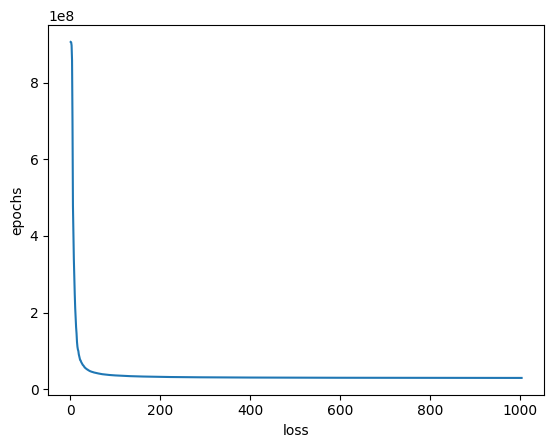

In [ ]:
plt.plot(range(1, epochs+1), loss_history)
plt.xlabel('loss')
plt.ylabel('epochs')
plt.show()

# Lets see the process of creation of our image


In [ ]:
# import numpy as np
# frames = [Image.fromarray(img) for img in gen_images]

# frames[0].save('gen_image.gif', format='GIF',
#     append_images=frames[1:],
#     save_all=True,
#     duration=len(frames) * 5,
#     loop=0
# )

In [ ]:
# from IPython.display import Image as DisplayImage

# DisplayImage(open('gen_image.gif','rb').read())

# Display generated image

In [ ]:
content_image = Denormalize(content_image)
style_image = Denormalize(style_image)
gen_image = Denormalize(gen_image)

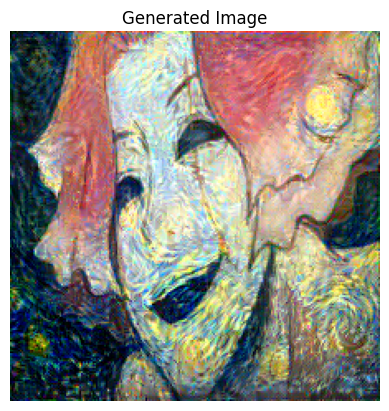

In [ ]:
plt.title('Generated Image')
plt.imshow(gen_image.detach().squeeze(0).permute(1, 2, 0).cpu().numpy().clip(0, 1))
plt.axis('off')
plt.show()